In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
tstamp = time.perf_counter_ns()

In [3]:
## import human data for fitting
import pandas as pd
hdf = pd.read_csv('../human_data.csv')
hB,hI = hdf.loc[:,('blocked mean','interleaved mean')].values.T

In [4]:
### RUN EXP
def run_batch_exp(ns,args):
  dataL = []
  for i in range(ns):
    task = Task()
    sem = SEM(args['sch'])
    exp,curr  = task.generate_experiment(**args['exp'])
    data = sem.run_exp(exp)
    data['exp']=exp
    dataL.append(data)
  return dataL

In [5]:
def get_sm(xth):
  """ 
  given x_t_hat from subject
  [trial,layer,node]
  get 2afc normalized softmax for layer 2/3
  return: [trial,layer2/3,node56/78]
  """
  nodes = {2:(5,6),3:(7,8)} 
  L = [] # layer 2 and 3
  for l,ns in nodes.items():
    y = xth[:,l,ns]
#     y /= y.sum(1,keepdims=True) # if nrom required
#     print(y/y.sum(1,keepdims=True))
#     y = softmax(xth[:,l,ns],-1)
    L.append(y)
  return np.array(L)

def get_acc(data):
  """ 
  returns 2afc softmax of 
  layer 2/3 transitions
  """
  ysm = get_sm(data['xth'])
  L = []
  for i in range(2):
    ysml = ysm[i]
    yt = data['exp'][:,i+3] 
    pr_yt = ysml[range(len(ysml)),yt - (5+2*i)] # 
    L.append(pr_yt)
  return np.array(L)

In [6]:
alfaL = [1.8,1.9,2.0]
betaL = [1,10,20]
betabL = [1,2,5] # bt
lmdaL = [0.01,0.1,0.2]

param_setsize = len(alfaL)*len(betaL)*len(lmdaL)*len(betabL)
print(param_setsize)
print(alfaL)
print(betaL)
print(betabL)
print(lmdaL)


expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
ns = 10

81
[1.8, 1.9, 2.0]
[1, 10, 20]
[1, 2, 5]
[0.01, 0.1, 0.2]


In [7]:
L = []
# for idx,(alfa,beta,lmda) in enumerate(product(alfaL,betaL,lmdaL)):
for idx,(alfa,beta,betab,lmda) in enumerate(product(alfaL,betaL,betabL,lmdaL)):
  params = alfa,beta,lmda
  print(idx/param_setsize,alfa,beta,lmda)
  schargs = {
    'concentration':alfa,
    'stickiness_wi':beta,
    'stickiness_bt':betab,
    'sparsity':lmda
  }
  args = {
    'sch':schargs,
    'exp':expargs
  }
  dataL = run_batch_exp(ns,args)
  acc = np.array([get_acc(data) for data in dataL]) # sub,layer,trial
  acc = acc.mean(1) # mean over layers
  test_acc = acc[(2,3),-40:].mean()
  mB = acc.mean(0)
  mse = np.mean((mB - hB)**2)
  ## record
  D = {**schargs,'mse':mse,'testacc':test_acc}
  L.append(D)


0.0 1.8 1 0.01
0.012345679012345678 1.8 1 0.1
0.024691358024691357 1.8 1 0.2
0.037037037037037035 1.8 1 0.01
0.04938271604938271 1.8 1 0.1
0.06172839506172839 1.8 1 0.2
0.07407407407407407 1.8 1 0.01
0.08641975308641975 1.8 1 0.1
0.09876543209876543 1.8 1 0.2
0.1111111111111111 1.8 10 0.01
0.12345679012345678 1.8 10 0.1
0.13580246913580246 1.8 10 0.2
0.14814814814814814 1.8 10 0.01
0.16049382716049382 1.8 10 0.1
0.1728395061728395 1.8 10 0.2
0.18518518518518517 1.8 10 0.01
0.19753086419753085 1.8 10 0.1
0.20987654320987653 1.8 10 0.2
0.2222222222222222 1.8 20 0.01
0.2345679012345679 1.8 20 0.1
0.24691358024691357 1.8 20 0.2
0.25925925925925924 1.8 20 0.01
0.2716049382716049 1.8 20 0.1
0.2839506172839506 1.8 20 0.2
0.2962962962962963 1.8 20 0.01
0.30864197530864196 1.8 20 0.1
0.32098765432098764 1.8 20 0.2
0.3333333333333333 1.9 1 0.01
0.345679012345679 1.9 1 0.1
0.35802469135802467 1.9 1 0.2
0.37037037037037035 1.9 1 0.01
0.38271604938271603 1.9 1 0.1
0.3950617283950617 1.9 1 0.2
0.407

In [8]:
gsdf = pd.DataFrame(L)
gsdf = gsdf.sort_values('testacc',ascending=False)
gsdf = gsdf.sort_values('mse',ascending=True)
best_param = gsdf.iloc[0]

# best fit

concentration     1.800000
stickiness_wi    20.000000
stickiness_bt     5.000000
sparsity          0.100000
mse               0.004372
testacc           0.932012
Name: 25, dtype: float64


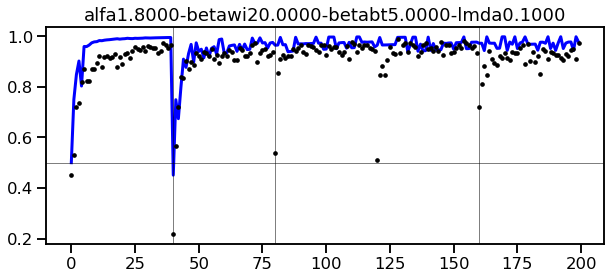

In [9]:
a,bw,bb,l = best_param[:4]

print(best_param)

schargs_prime = {
  'concentration':a,
  'stickiness_wi':bw,
  'stickiness_bt':bb,
  'sparsity':l
}
args = {
  'sch':schargs_prime,
  'exp':expargs
  }
dataL = run_batch_exp(ns,args)
acc = np.array([get_acc(data) for data in dataL]) # sub,layer,trial
acc = acc.mean(1) # mean over layers
mB = acc.mean(0)

## plot
plt.figure(figsize=(10,4))
plt.plot(mB,c='b',lw=3)
plt.scatter(range(len(hB)),hB,c='k',s=10,zorder=99)
plt.axhline(0.5,c='k',lw=0.5)
for v in [40,80,160]:
  plt.axvline(v,c='k',lw=0.5)

  
paramstr = "alfa%.4f-betawi%.4f-betabt%.4f-lmda%.4f"%(a,bw,bb,l)
plt.title(paramstr)

plt.savefig('figures/scratch/bestfitGS-%i'%tstamp)

# analysis

In [10]:
pL = ['concentration','stickiness_bt','stickiness_wi','sparsity']

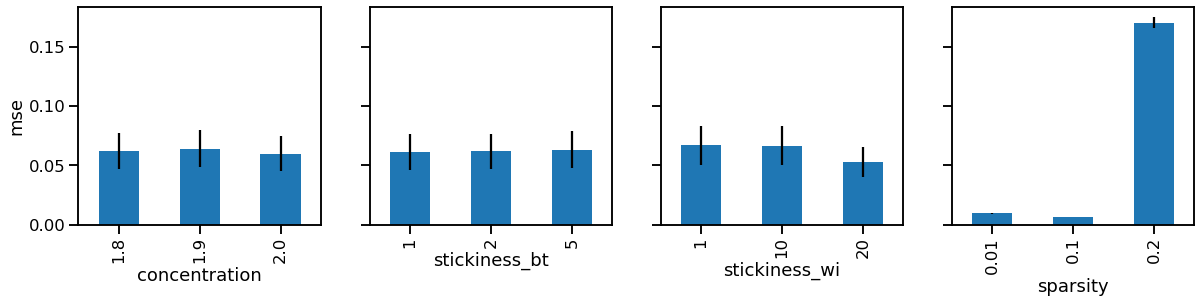

In [11]:
f,axa = plt.subplots(1,4,figsize=(20,4),sharey=True)
for i in range(4):
  ax = axa[i]
  msegroup = gsdf.groupby(pL[i]).mse
  M = msegroup.mean()
  S = msegroup.std()/np.sqrt(msegroup.count())
#   ax.bar(M)
  M.plot.bar(ax=ax,yerr=S)
#   ax.bar(M,yerr=S)
#   ax.fill_between(M.index,M+S,M-S,alpha=0.5)
  ax.set_xlabel(pL[i])
  ax.set_ylabel('mse')

plt.savefig('figures/scratch/mse-by-param-%i'%tstamp)

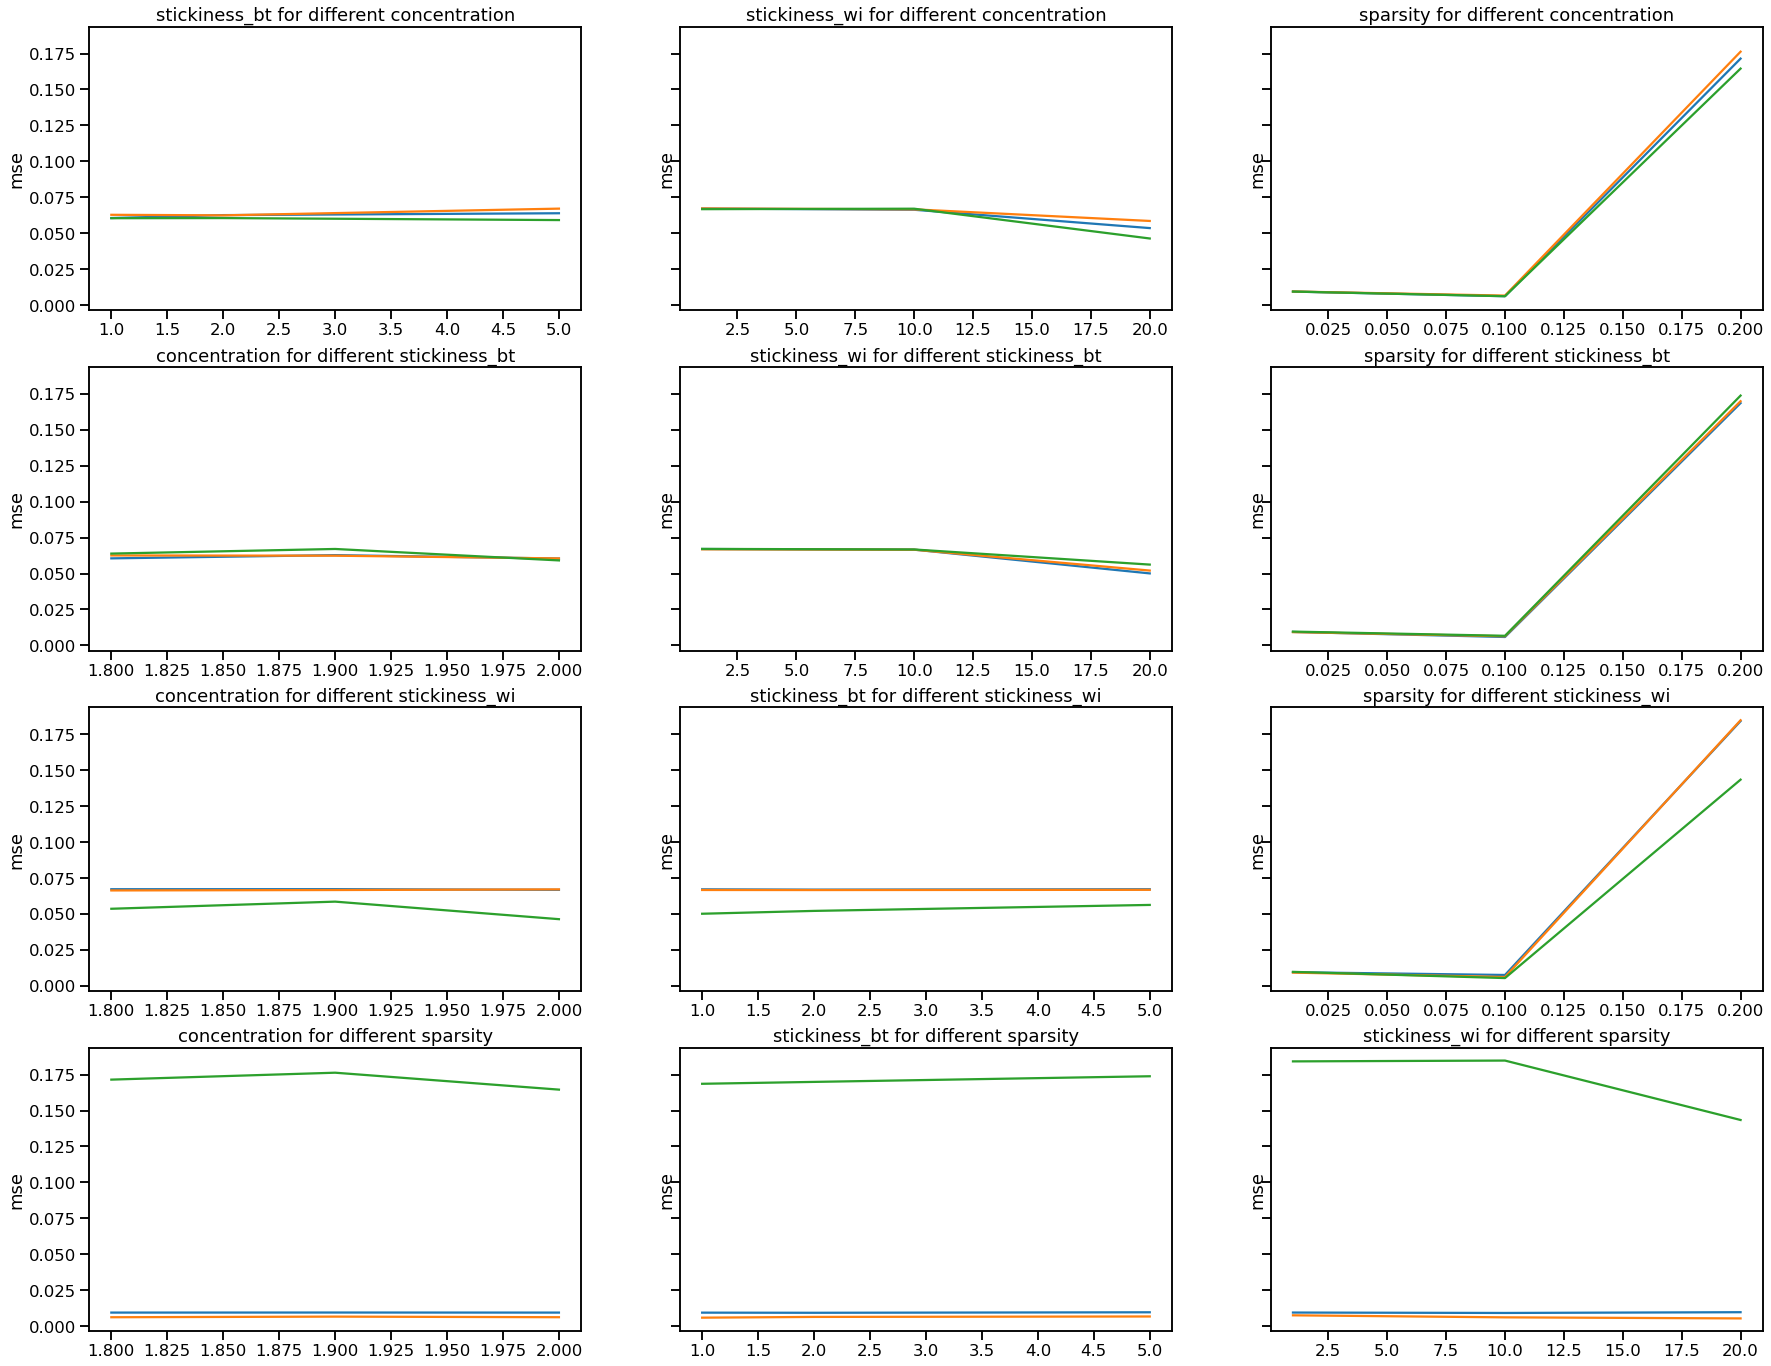

In [12]:
f,axa = plt.subplots(4,3,figsize=(30,24),sharey=True)
for oi,outvar in enumerate(pL):
  ii=-1
  for invar in pL:
    if outvar==invar: continue
    ii+=1
    ax = axa[oi,ii]
    for oval,d in gsdf.groupby([outvar,invar]).mean().groupby(outvar):
      xplt = d.reset_index().loc[:,invar]
      yplt = d.mse.values
      ax.set_title('%s for different %s'%(invar,outvar))
      ax.plot(xplt,yplt)
      ax.set_ylabel('mse')
#       ax.set_ylim(0,0.025)
      
plt.savefig('figures/scratch/mse-by-paramXparam-%i'%tstamp)